In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sin, cos, atan2, sqrt, pi, radians
import statsmodels.api as sm

%matplotlib inline

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Load data and Visualize

### 1. Create a data frame which contains multiple data frames

In [3]:
# Each row represents each individual road
df_road = pd.read_csv("_roads2_original.csv")
road_num = df_road['road'].unique()
df_road = pd.DataFrame(data = [[road[0], road, df_road[df_road['road'] == road]] for road in road_num],
                       columns = ['class', 'road', 'data_frame'])
df_road.head()

,class,road,data_frame
0,N,N1,road chainage lrp lat ...
1,N,N101,road chainage lrp lat ...
2,N,N102,road chainage lrp lat ...
3,N,N103,road chainage lrp lat ...
4,N,N104,road chainage lrp lat ...


### 2. Visualize the entire roads

Text(0.5,1,'Road Visualization')

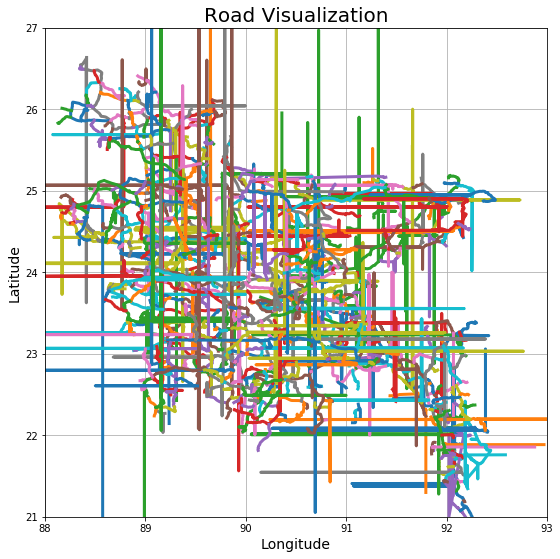

In [4]:
road_class = ["N", "Z", "R"]

plt.figure(figsize = (9,9))
for j in range(len(road_class)):
    for i in range(len(df_road)):
        if df_road["class"][i] == road_class[j]:
            df = df_road["data_frame"][i]
            plt.plot(df["lon"], df["lat"], lw = 3,
                     label = df_road["road"][i])
plt.xlim(88,93)
plt.ylim(21,27)

plt.grid()
plt.xlabel("Longitude", size = 14)
plt.ylabel("Latitude", size = 14)
plt.title("Road Visualization", size = 20)

## Key algorithms for the cleaning
### "Local Regression" (Polynomial X)
#### Road inherently has "both" global and local trend.
#### : It goes from the start A to the end B (global), however, many curvatures exist (local) in the middle. In order to capture the 'true' trend, we need to consider both global and local trend.
#### Local Regression is selected instead of the polynomial regression, as it uses local (neigboring) data points proportionally with certain weights. This leads better result by reflecting both local and global trend for estimation.
1. Polynomial Regression may fail, as it fits the entire data points at once. Hence the local trend can be ignored.
2. Defining the order (x^2, x^3, x^4...) can be too arbitrary since the road shapes are highly varying.
3. It is also inappropriate, especially when the start and/or end point are wrong or missing. In this case, the extrapolation will high-order polynomial regression often leads an overly high variance.

In [5]:
# Select an arbitrary road: N1
df = df_road['data_frame'].iloc[0]
df.head()

,road,chainage,lrp,lat,lon,type,name
0,N1,0.000,LRPS,23.706028,90.443333,Others,Start of Road after Jatrabari Flyover infront...
1,N1,0.814,LRPSa,23.702917,90.450417,Culvert,Box Culvert
2,N1,0.822,LRPSb,23.702778,90.450472,CrossRoad,Intersection with Z1101
3,N1,1.000,LRP001,23.702139,90.451972,KmPost,Km post missing
4,N1,2.000,LRP002,23.697889,90.460583,KmPost,Km post missing


In [6]:
# This function defines the distance between two locations.
def distance(loc1, loc2, R = 6380):
    #change the value into radians
    lat1 = radians(float(loc1[0]))
    lon1 = radians(float(loc1[1]))
    
    lat2 = radians(float(loc2[0]))
    lon2 = radians(float(loc2[1]))
    
    #calculate the distance
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = (sin(dlat/2))**2 + cos(lat1) * cos(lat2) * (sin(dlon/2))**2
    c = 2 * atan2( sqrt(a), sqrt(1-a) )
    d = R * c # where R is the radius of the Earth
    return d

### 1. Visual Checking
#### The detection of the abnormal points are done through the visualization of the entire picture of the road data
#### Main Purpose: "Detecting" all possible (seemingly) abnormal points. How to detect?
1. Outliers(i.e. out-of-trend): fitting into the (estimated) true location defined by local regression method.
2. Far-away points: checking the distance between two points further than 10km. (10km can be adjusted by the parameter 'dis' later.)

#### Why multiple algorithms?
※ Abnormal points are screend out by using 'ratio' (Algorithm 1) and 'absolute distance' (Algorithm 2). These two algorithms are <b><u>mutually complementary</u></b> in a sense that 1 is 'soft' correction and 2 is 'hard' correction. If the extent of deviation is extremely large (for instance, the wrong location beyond Africa), the local regression (Algorithm 1) fails to detect, as it gives a certain weight to the local value. In this case, to double-check the absolute distance (Algorithm 2) can be the solution. Yet, to only use Algorithm 2 will fail 1) to capture the most probable trend of the road, 2) to make a proper correction when start and/or end points are wrong.

In [7]:
def visual_check(df, n = 5, cols = ['lat', 'lon'], nbr = 20, bar = 0.001, dis = 10, names = ["Latitude", "Longitude"]):
    """
    Main Purpose: "Detection" of abnormal points
    1. Outliers(i.e. out-of-trend) by fitting into the (estimated) true trend (defined by local regression)
    2. Far-away points which have further distance than 10km (10km can be adjusted by the parameter 'dis')
    """
    x = np.linspace(0,1,len(df))
    frac = nbr/len(df)
    df['x'] = x
    
#     distance checker between two neiboring points
    d = []
    for i in range(len(df)-1):
        loc1 = [df[cols].iloc[i][0], df[cols].iloc[i][1]]
        loc2 = [df[cols].iloc[i+1][0], df[cols].iloc[i+1][1]]
        d.append(distance(loc1, loc2))
    df['distance'] = np.array([None] + d)
    
    
#     plot
    plt.figure(figsize = (15, 7))
    for i in range(len(cols)):
        y = df[cols[i]]
#         lowess will returns a smoothed data set, namely the "true trend line"
        lowess = sm.nonparametric.lowess(y, x, frac)
        yest = list(zip(*lowess))[1]
        
        df['est'] = yest
        df['ratio'] = abs(y/yest - 1)
        suspicious = df.sort_values(by = 'ratio', ascending = False)[:n]
        
        plt.subplot(1, len(cols), i+1)
        
#         plot data
        plt.plot(x, y, label='Road data', ls = '--')
    
#         plot trend line
        plt.plot(x, yest, label='True location (estimated trend)', lw = 5, alpha = 0.2, color = 'red')
    
#         plot far-away points
        plt.scatter(x[np.array(df['distance'] > dis)], y[df['distance'] > dis],color = 'green',
                    label = 'far away >{dis} km'.format(dis = dis))
    
#         plot outliers
        plt.scatter(x[np.array(abs(y/yest - 1) > bar)], y[abs(y/yest - 1) > bar], s = 50, color = 'black',
                    label='outliers (>{bar}% deviation)'.format(bar = bar * 100))
    
#         plot top 5 suspicious points
        plt.scatter(suspicious['x'], suspicious[cols[i]],
                    marker = "o", s = 100, facecolors = "none", edgecolors = 'red', linewidths = 2,
                    label='top {num}'.format(num = n))     
        plt.ylabel(names[i], size = 14)
        plt.title("{name} Decomposition".format(name = names[i]), size = 20)
        plt.legend(fontsize = "large")
        
#         print(suspicious[["road", "chainage", "lrp", "lat", "lon"]])
#         print("num outliers: ", sum(abs(y/yest - 1) > bar))

### Description of the graph
1. The vector is decomposed into two elements (x-axis, y-axis), as many abnormal points has wrong value in either latitude or longitude.
2. Types of abnormality
    - Outliers: Black dots indicates data points which deviate more than 0.1% from the trend line.
    - Far-away: Green dots indicates data points which is far more than 10km from the neigboring point.
3. Red circle indicates data points which most deviate by rank, based on its absolute value. Thus, it may force to show such points even though they don't deviate so much.
4. Blue dotted line indicates data points.
5. Pink line indicates an overall trend. (estimated by the local regression)

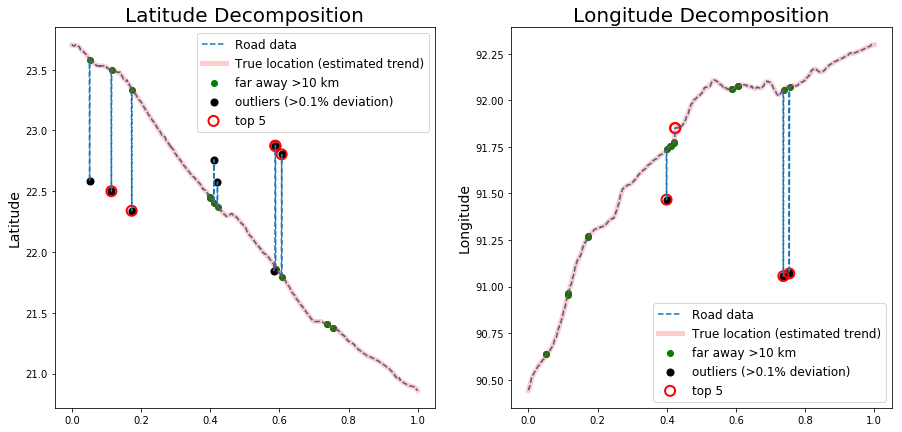

In [8]:
visual_check(df)

### 2. Correct the abnormal points
####     Correcting algorithm
1. Outliers: Fit to the trend line
2. Far-away points: Interpolate
3. Iterate 1 and 2, until no such points are observed.

In [9]:
def smoothing(df, cols = ['lat', 'lon'], nbr = 20, bar = 0.001, dis = 10):
    """
    Correcting algorithm
    1. Outliers: Fit to the trend line
    2. Far-away points: Drop and Interpolate
    3. Iterate 1 and 2, until no such points are observed.
    """
#     iterate running the script until no outliers and far-away points are detected.
    num_strange = [1, 1, 1]
    while (sum(num_strange) > 0):
#         1. outliers correction
        x = np.linspace(0,1,len(df))
        frac = nbr/len(df)
        df['x'] = x

        num_strange = [1,1,1]

        for i in range(len(cols)):
#             run local regression
            y = df[cols[i]]
            lowess = sm.nonparametric.lowess(y, x, frac)
            yest = np.array(list(zip(*lowess))[1])

#             record the number of outliers
            num_strange[i] = sum(abs(y/yest - 1) > bar)

#             fit outliers to the estimated trend
            idx = y[abs(y/yest - 1) > bar].index
            new_val = yest[np.array(abs(y/yest - 1) > bar)]
            y = y.where(abs(y/yest - 1) <= bar)
            d = dict(zip(idx, new_val))
            y.fillna(d, inplace = True)
            df[cols[i]] = y

#         2. far-away points correction
        d = []
        for i in range(len(df)-1):
            loc1 = [df[cols].iloc[i][0], df[cols].iloc[i][1]]
            loc2 = [df[cols].iloc[i+1][0], df[cols].iloc[i+1][1]]
            d.append(distance(loc1, loc2))
        df['distance'] = np.array([None] + d)
        
#         record the number of far-away points
        num_strange[2] = len(df.where(df['distance'] > dis).dropna())
        
#         interpolate far-away points 
        df.set_value(df.where(df['distance'] > dis).dropna().index, ['lat', 'lon'], None)
        df[['lat', 'lon']] = df[['lat', 'lon']].interpolate()

    return df

### Major parameters for two functions
1. nbr (default = 20): number of data points in a subset which is given weights.
    - Small value will fit more to local trend.
2. bar (defalut = 0.001): criterion to define outliers
3. dis (defalut = 10): criterion to define far-away points

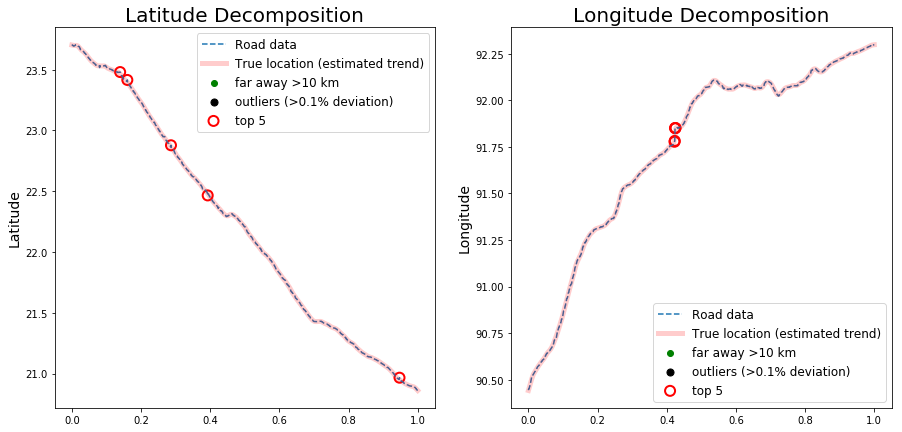

In [10]:
# run smoothing function and visualize again
df = smoothing(df)
visual_check(df)

#### No more black and green dots are observed.

### Some tests on other roads

#### Before 1

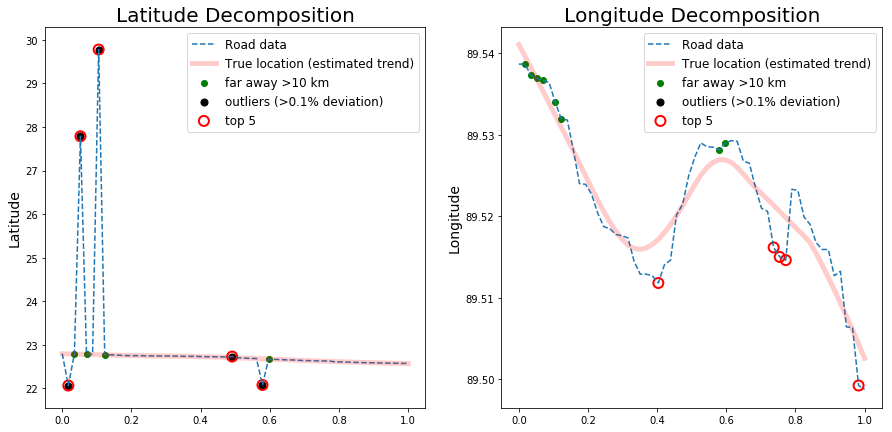

In [11]:
df = df_road['data_frame'].iloc[760]
visual_check(df)
df = smoothing(df)

#### After 1

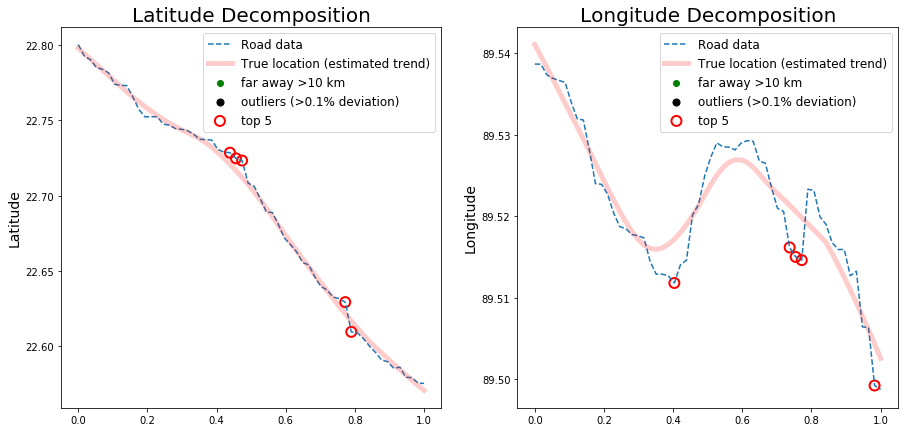

In [12]:
visual_check(df)

#### Before 2

※ Right-hand Panel: The local regression fails to detect the abnormal point (it is not black), yet it is detected as a 'far-away' point (green dot). As mentioned above, two algorithms work together.

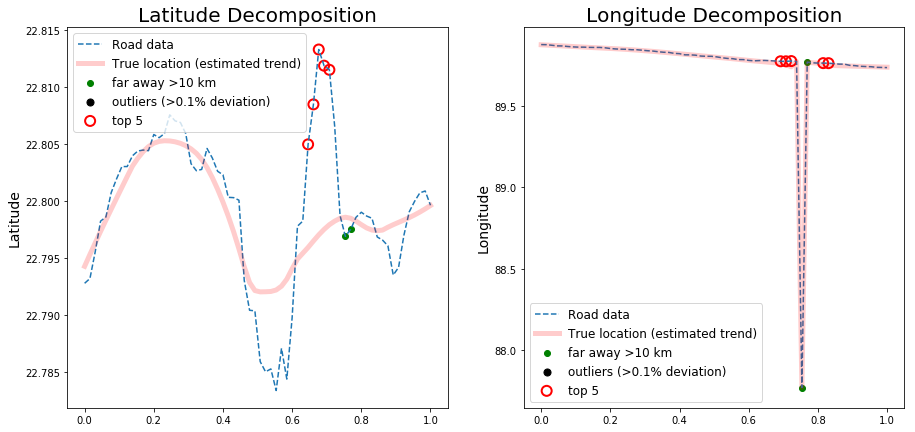

In [14]:
df = df_road['data_frame'].iloc[785]
visual_check(df)
df = smoothing(df)

#### After 2

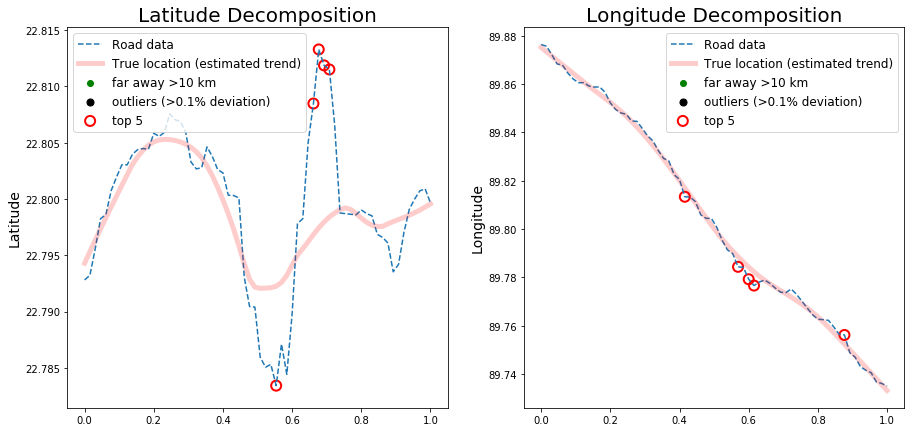

In [15]:
visual_check(df)

#### Before 3

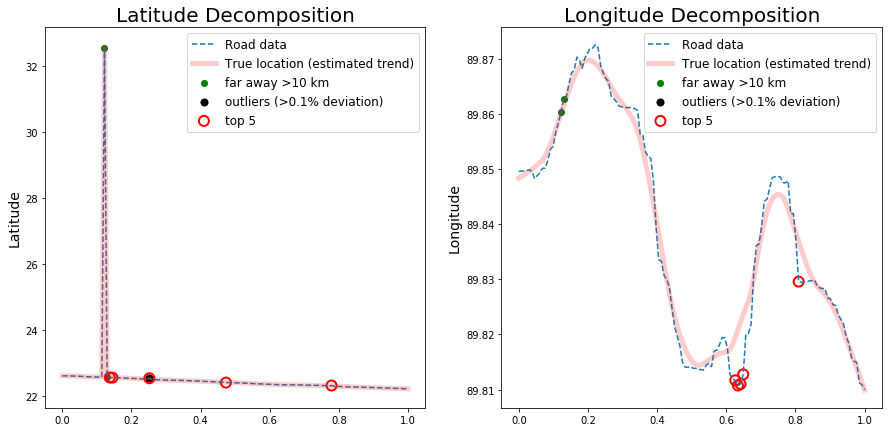

In [16]:
df = df_road['data_frame'].iloc[770]
visual_check(df)
df = smoothing(df)

#### After 3

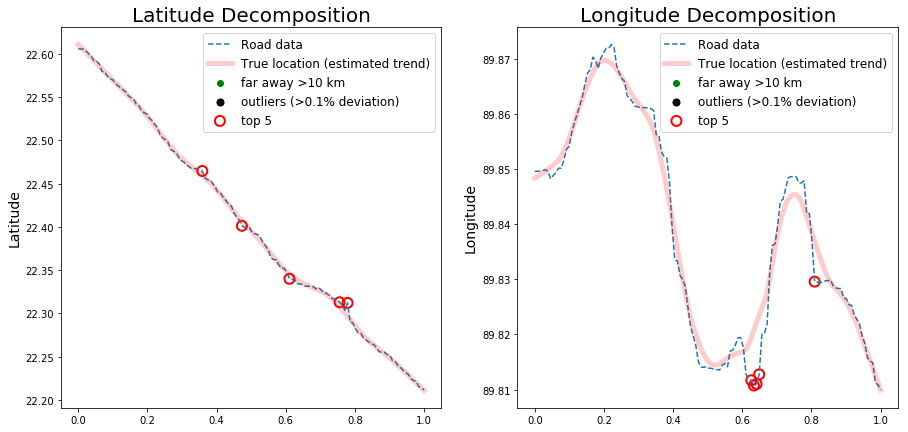

In [17]:
visual_check(df)

#### Before 4

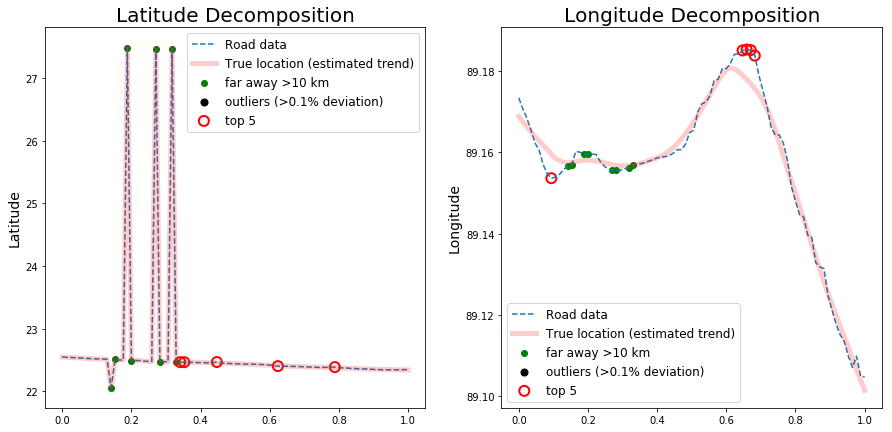

In [18]:
df = df_road['data_frame'].iloc[767]
visual_check(df)
df = smoothing(df)

#### After 4

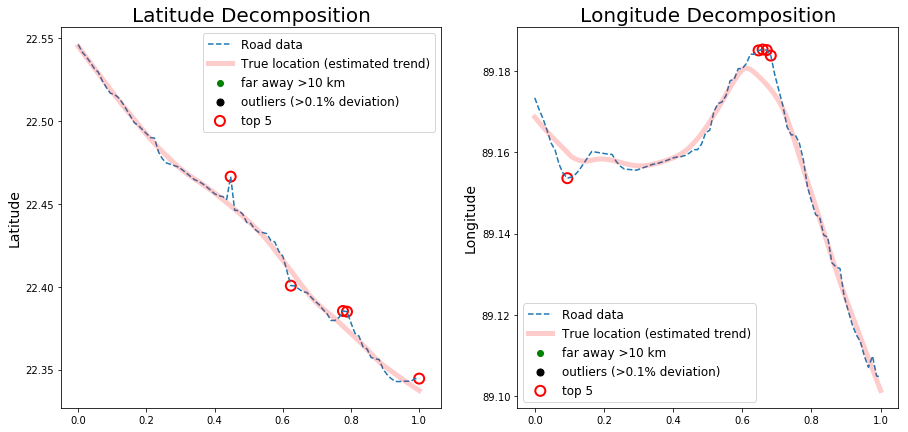

In [19]:
visual_check(df)

#### After 4 - 1
small remaining bumps can be eliminated by lower the parameter 'dis' to 2, later

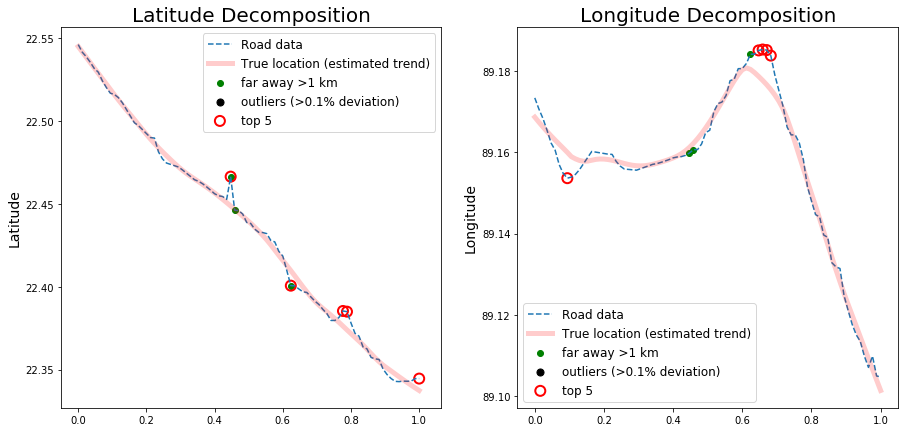

In [21]:
visual_check(df, dis = 1)
#this will be done later.

#### Before 5

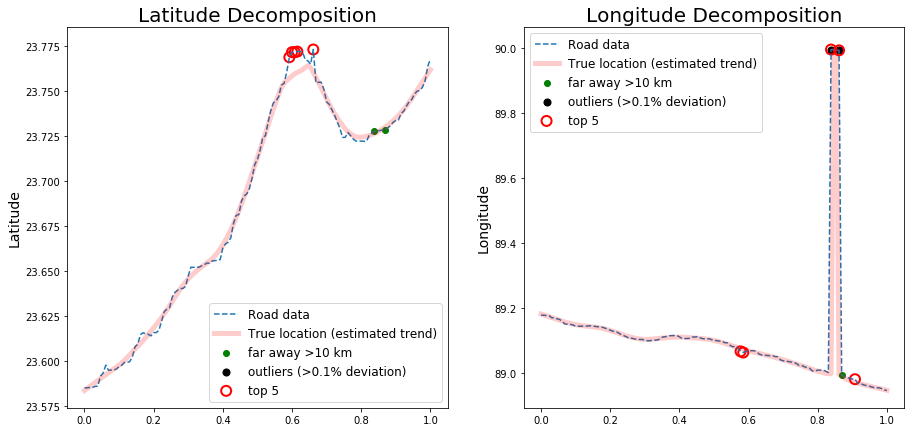

In [22]:
df = df_road['data_frame'].iloc[724]
visual_check(df)
df = smoothing(df)

#### After 5

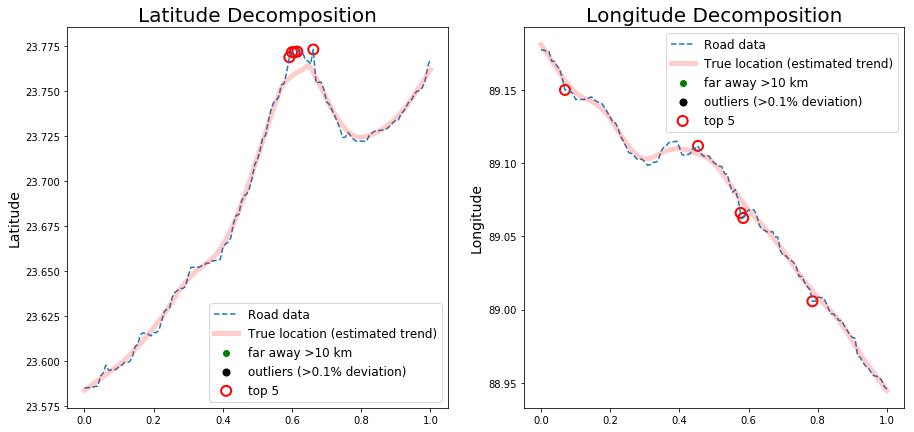

In [23]:
visual_check(df)

## 3. Finalize
### 1. First filtering: Run the code for the entire data set!

In [24]:
#load data
df_road = pd.read_csv("_roads2_original.csv")
road_num = df_road['road'].unique()
df_road = pd.DataFrame(data = [[road, df_road[df_road['road'] == road]] for road in road_num],
                       columns=['road', 'data_frame'])

#run smoothing for all data
df_all = pd.DataFrame()
for i in range(len(df_road)):
    if i % 100 == 0:
        print(round(i/len(df_road)*100), "%")
    df = df_road["data_frame"][i]
    new_df = smoothing(df)
    df_all = pd.concat([df_all, new_df[['road', 'chainage', 'lrp', 'lat', 'lon', 'type', 'name']]])
print(100,"%")

# save to csv file
df_all.to_csv("_roads2_edit1.csv", index = False)

0 %
11 %


C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in true_divide
  res = _lowess(y, x, frac=frac, it=it, delta=delta)


23 %
34 %
46 %
57 %
68 %
80 %
91 %
100 %


#### Visualize the first result

Text(0.5,1,'Road Visualization')

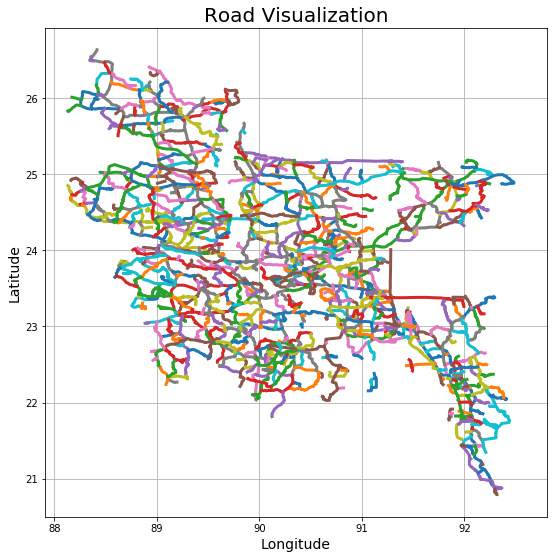

In [25]:
df_road = pd.read_csv("_roads2_edit1.csv")
road_num = df_road['road'].unique()
df_road = pd.DataFrame(data = [[road[0], road, df_road[df_road['road'] == road]] for road in road_num],
                       columns = ['class', 'road', 'data_frame'])

road_class = ["N", "Z", "R"]

plt.figure(figsize = (9,9))
for j in range(len(road_class)):
    for i in range(len(df_road)):
        if df_road["class"][i] == road_class[j]:
            df = df_road["data_frame"][i]
            plt.plot(df["lon"], df["lat"], lw = 3,
                     label = df_road["road"][i])

plt.grid()
plt.xlabel("Longitude", size = 14)
plt.ylabel("Latitude", size = 14)
plt.title("Road Visualization", size = 20)

### The first smoothing has completed. Overall, roads seem to be clean.
#### Still, some errors and small bumps are observed.

### 2. Second filtering
#### This data set will be filtered again by using a lower parameter (dis = 1km)

In [27]:
#load data
df_road = pd.read_csv("_roads2_edit1.csv")
road_num = df_road['road'].unique()
df_road = pd.DataFrame(data = [[road, df_road[df_road['road'] == road]] for road in road_num],
                       columns=['road', 'data_frame'])

#run smoothing for all data
df_all = pd.DataFrame()
for i in range(len(df_road)):
    if i % 100 == 0:
        print(round(i/len(df_road)*100), "%")
    df = df_road["data_frame"][i]
    new_df = smoothing(df, dis = 1)
    df_all = pd.concat([df_all, new_df[['road', 'chainage', 'lrp', 'lat', 'lon', 'type', 'name']]])
print(100,"%")

# save to csv file
df_all.to_csv("_roads2.csv", index = False)

0 %
11 %


C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in true_divide
  res = _lowess(y, x, frac=frac, it=it, delta=delta)


23 %
34 %
46 %
57 %
68 %
80 %
91 %
100 %


Text(0.5,1,'Road Visualization')

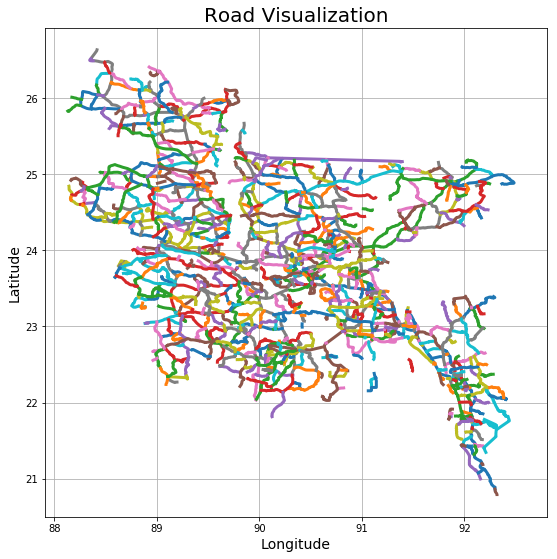

In [28]:
df_road = pd.read_csv("_roads2.csv")
road_num = df_road['road'].unique()
df_road = pd.DataFrame(data = [[road[0], road, df_road[df_road['road'] == road]] for road in road_num],
                       columns = ['class', 'road', 'data_frame'])

road_class = ["N", "Z", "R"]

plt.figure(figsize = (9,9))
for j in range(len(road_class)):
    for i in range(len(df_road)):
        if df_road["class"][i] == road_class[j]:
            df = df_road["data_frame"][i]
            plt.plot(df["lon"], df["lat"], lw = 3,
                     label = df_road["road"][i])

plt.grid()
plt.xlabel("Longitude", size = 14)
plt.ylabel("Latitude", size = 14)
plt.title("Road Visualization", size = 20)